In [1]:
%matplotlib inline

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio
from astropy.table import Table

In [3]:
### Starry Configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [4]:
### Read in data

data_table = Table.read('GaiaDR2_4616932063282660608.csv',format='csv')

In [5]:
### Choose Sector

sector = 27

In [6]:
### Load in sector

sec = data_table[data_table['sector']==sector]

In [7]:
### Rotation Period

period_days = 5.19
period_hours = 5.19 * 24

In [8]:
### Set flux and time array for sectors

sector_flux = np.array(sec['flux'])

sector_time = np.array(sec['time'])

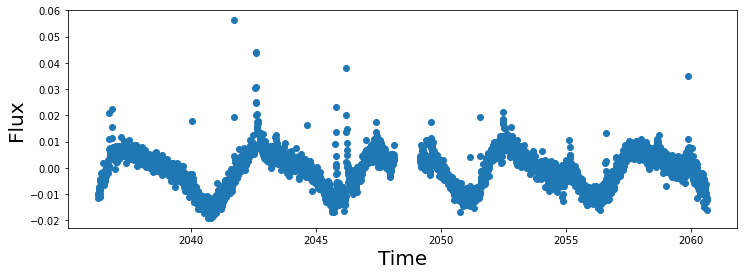

In [14]:
### Plotting the light curve

fig, ax = plt.subplots(1, figsize=(12, 4))
plt.scatter(sector_time,sector_flux)
ax.set_ylabel("Flux", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
plt.show()

In [15]:
### Normalize flux array to 1

sector_flux_normalized = sector_flux+1

In [16]:
### Calculate Error

flux_error = (sector_flux_normalized) * 0.05

In [17]:
### Choose ydeg for maps

ydeg = 2

In [18]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=ydeg, reflected=False)
map.obl = 0
map.inc = 90

In [19]:
## set the data vector (the flux and the covariance matrix)
map.set_data(sector_flux_normalized, C=flux_error**2)

In [20]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [21]:
### More map variables

nrot=max(sector_time)/period_days # Calculate the number of rotations
npts = len(sector_time) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(sector_time, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [22]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 612 ms, sys: 388 ms, total: 1 s
Wall time: 5.39 s


In [23]:
### Save map image

map.show(colorbar=True, projection="moll",file="sector"+str(sector)+"_ydeg"+str(ydeg)+"_map.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


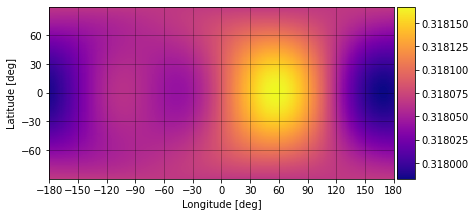

In [29]:
### Plot map

map.show(colorbar=True, projection="rect")

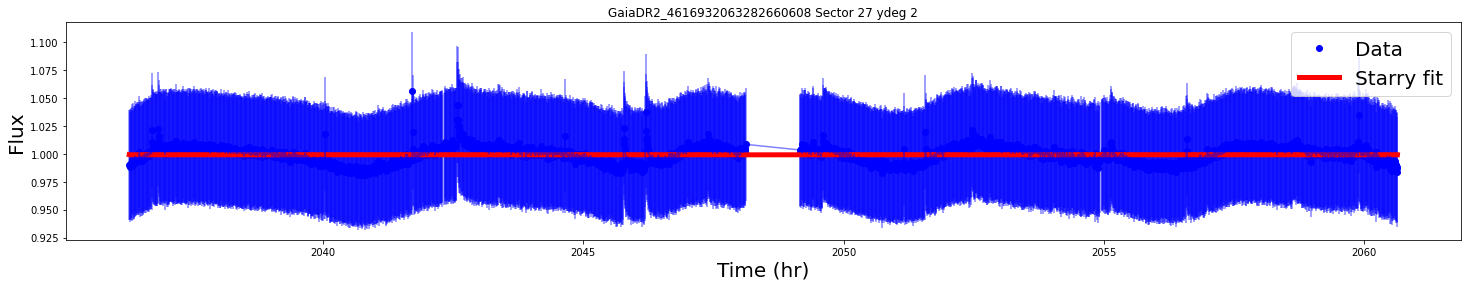

In [27]:
### Plotting light curve with Starry fit

fig, ax = plt.subplots(1, figsize=(25, 4))
plt.title("GaiaDR2_4616932063282660608 Sector " + str(sector)+" ydeg "+str(ydeg))
plt.plot(sector_time, sector_flux_normalized,label="Data",linestyle="none",marker="o",color="blue")
#plt.ylim(0.98,1.02)
plt.plot(sector_time, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(sector_time,sector_flux_normalized , flux_error,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Flux", fontsize=20)
plt.savefig("sector"+str(sector)+"_ydeg"+str(ydeg)+".jpg")